# Graph Analyses
Here, we'll perform various analysis by constructing graphs and measure properties of those graphs to learn more about the data

In [1]:
import csv
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.spatial import Delaunay
import numpy as np
import math
import skimage
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import future
import networkx as nx
from ragGen import *
%matplotlib inline
sns.set_color_codes("pastel")

In [2]:
# Read in the data
data = open('../../data/data.csv', 'r').readlines()
fieldnames = ['x', 'y', 'z', 'unmasked', 'synapses']
reader = csv.reader(data)
reader.next()

rows = [[int(col) for col in row] for row in reader]

# These will come in handy later
sorted_x = sorted(list(set([r[0] for r in rows])))
sorted_y = sorted(list(set([r[1] for r in rows])))
sorted_z = sorted(list(set([r[2] for r in rows])))

We'll start with just looking at analysis in euclidian space, then thinking about weighing by synaptic density later. Since we hypothesize that our data will show that tissue varies as we move down the y-axis (z-axis in brain) through cortical layers, an interesting thing to do would be compare properties of the graphs on each layer (ie how does graph connectivity vary as we move through layers).

Let's start by triangulating our data. We'll use Delaunay on each y layer first. Putting our data in the right format for doing graph analysis...

In [3]:
a = np.array(rows)
b = np.delete(a, np.s_[3::],1)

# Separate layers - have to do some wonky stuff to get this to work
b = sorted(b, key=lambda e: e[1])
b = np.array([v.tolist() for v in b])
b = np.split(b, np.where(np.diff(b[:,1]))[0]+1)

Now that our data is in the right format, we'll create 52 delaunay graphs. Then we'll perform analyses on these graphs. A simple but useful metric would be to analyze edge length distributions in each layer.

In [4]:
graphs = []
centroid_list = []

for layer in b:
    centroids = np.array(layer)
    
    # get rid of the y value - not relevant anymore
    centroids = np.delete(centroids, 1, 1)
    centroid_list.append(centroids)
    
    graph = Delaunay(centroids)
    graphs.append(graph)

We're going to need a method to get edge lengths from 2D centroid pairs

In [5]:
def get_d_edge_length(edge):
    (x1, y1), (x2, y2) = edge
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

In [6]:
edge_length_list = [[]]
tri_area_list = [[]]

for del_graph in graphs:
    
    tri_areas = []
    edge_lengths = []
    triangles = []

    for t in centroids[del_graph.simplices]:
        triangles.append(t)
        a, b, c = [tuple(map(int,list(v))) for v in t]
        edge_lengths.append(get_d_edge_length((a,b)))
        edge_lengths.append(get_d_edge_length((a,c)))
        edge_lengths.append(get_d_edge_length((b,c)))
        try:
            tri_areas.append(float(Triangle(a,b,c).area))
        except:
            continue
    edge_length_list.append(edge_lengths)
    tri_area_list.append(tri_areas)

Realizing after all this that simply location is useless. We know the voxels are evenly spaced, which means our edge length data will be all the same. See that the "centroids" are no different:

In [7]:
np.subtract(centroid_list[0], centroid_list[1])

array([[0, 0],
       [0, 0],
       [0, 0],
       ..., 
       [0, 0],
       [0, 0],
       [0, 0]])

There is no distance between the two. Therefore it is perhaps more useful to consider a graph that considers node weights. Voronoi is dual to Delaunay, so that's not much of an option. We want something that considers both spacial location and density similarity. 

## Region Adjacency Graph (RAG)

In the past we've considered density information alone (ie analysis density histogram distribution) and above we are considering only spacial information, which totally doesn't say anything. To construct a graph that consider both spacial and density information, we'll use a Region Adjacency Graph (RAG).

In RAGs, two nodes are considered as neighbor if they are close in proximity (separated by a small number of pixels/voxels) in the horizontal or vertical direction.

<img src="../../docs/figures/plot_rag_1.png" width="400">

Since our data includes density values at each node (voxel, or pixel since we're looking at y-layers), we can weight by the inverse of density difference between two nodes. Inverse because strongly connected nodes should be close in weight.

We have number of synapses S<sub>i</sub> at nodes $i$ and define weights $w$ between the nodes:

$$w = \dfrac{1}{S_i - S_{i+1}}$$

RAGs are used largely in image processing, and it makes sense for our data to look more like an image. Since the data is evenly spaced, the absolute locations of the voxels don't matter. We can use the index in the matrix to represent spacial location, with the value at each pixel being the synapse density at that voxel. We've done this before in "real volume"

In [8]:
real_volume = np.zeros((len(sorted_y), len(sorted_x), len(sorted_z)))
for r in rows:
    real_volume[sorted_y.index(r[1]), sorted_x.index(r[0]), sorted_z.index(r[2])] = r[-1]
    
vol = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    vol[sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

In [9]:
np.shape(real_volume)

(52, 108, 11)

### Testing the RAG generator

In [10]:
test_im = real_volume[1]
shape = np.shape(test_im)

ragu = generate_rag(test_im, False)
ragu.number_of_edges()
# ragu.adjacency_list()

2257

### Creating RAGs for each layer

In [11]:
y_rags = []
for layer in real_volume:
    y_rags.append(generate_rag(layer, False))

OK, great! Now we have a list of 52 region adjacency graphs for each y-layer. Now we want to measure properties of those graphs and see how the properties vary in the y direction - through what we hypothesize are the cortical layers.

### Number of Edges

This is just a sanity check. They should all be the same if we did it right!

In [12]:
num_edges = []
for rag in y_rags:
    num_edges.append(rag.number_of_edges())

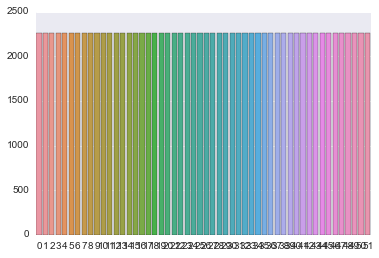

In [13]:
sns.barplot(x=range(len(num_edges)), y=num_edges)
sns.plt.show()

### Drawing Graphs

First we look at the default networkx graph plotting:

We're gonna need to massage the drawing function a bit in order to get the custom positional graph to work.

In [14]:
# for rag in y_rags:
#     plt.figure()
#     nx.draw(rag, node_size=100)

This is using the spring layout, so we're losing positional information. We can improve the plot by adding position information.

## Edge Weight Stats

In [15]:
def get_edge_weight_distributions(rags):
    distributions = []
    for rag in rags:    
        itty = rag.edges_iter()
        weight_list = []
        for index in range(rag.number_of_edges()):
            eddy = itty.next()
            weight_list.append(rag.get_edge_data(eddy[0], eddy[1])['weight'])

        distributions.append(weight_list)
    return distributions

In [54]:
distributions = get_edge_weight_distributions(y_rags)
distributions = distributions

Note that we put padding on the data, ignoring the edge layers which appear to be inconsistent due to data generation methods (ie there is no tissue there)

### Full edge weight histograms down y-axis

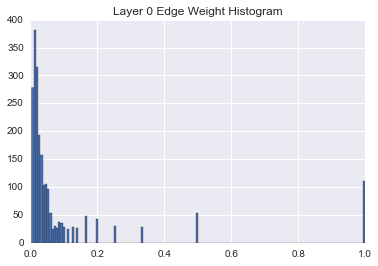

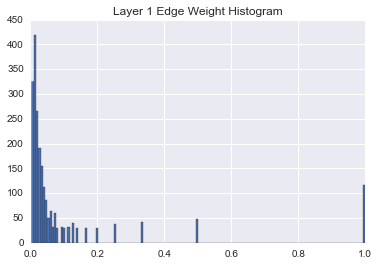

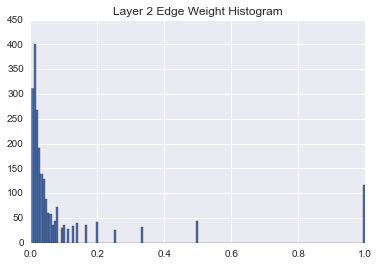

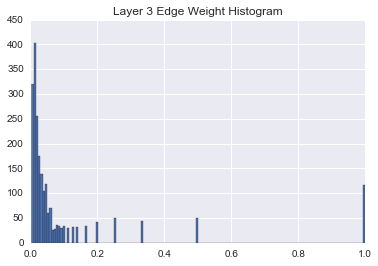

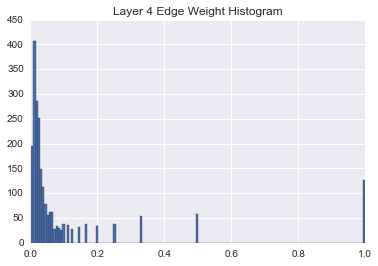

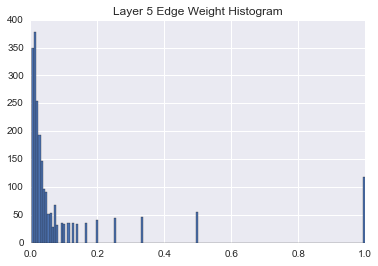

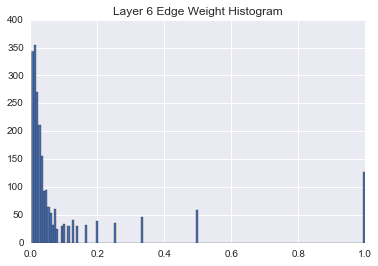

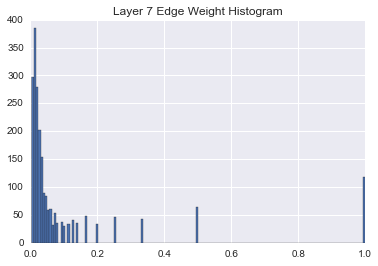

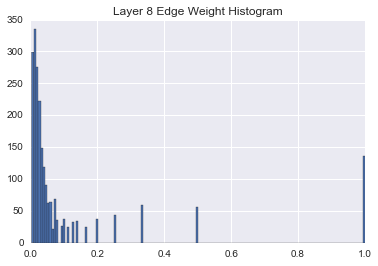

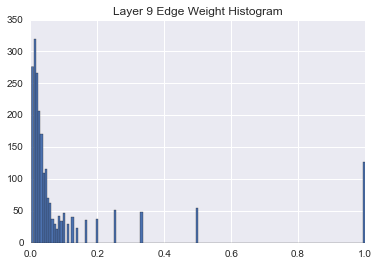

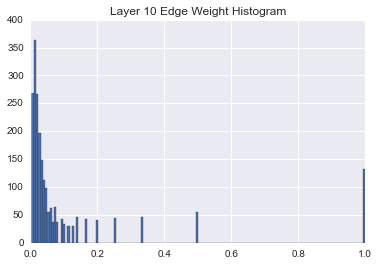

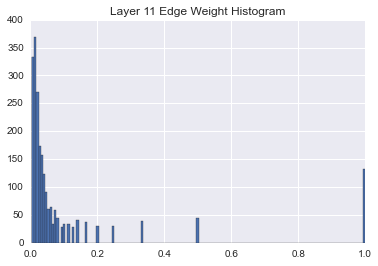

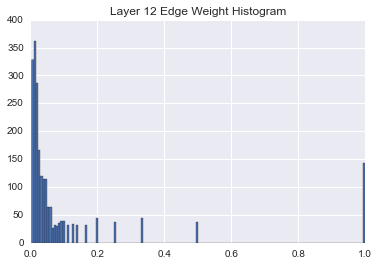

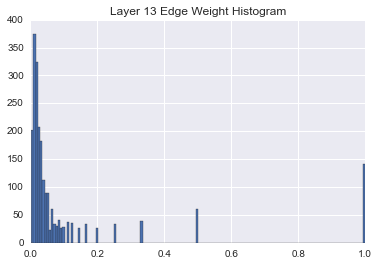

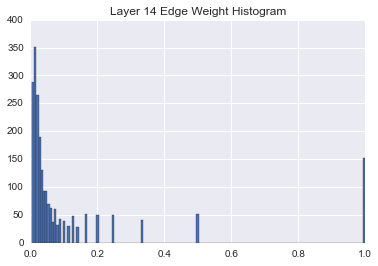

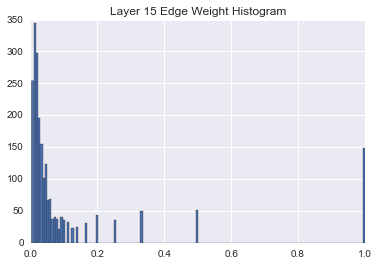

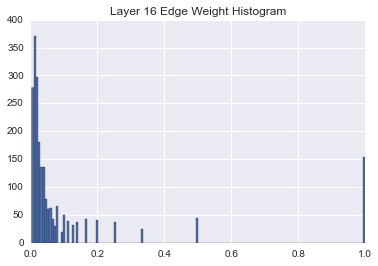

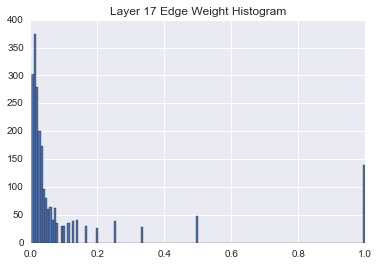

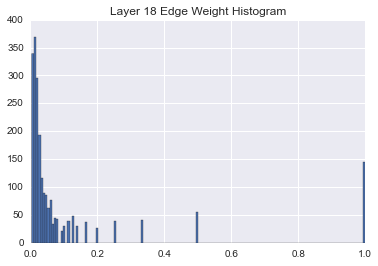

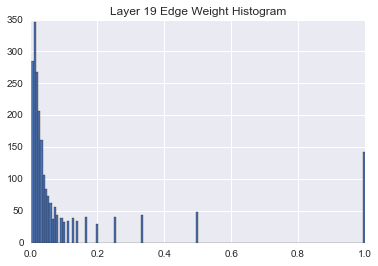

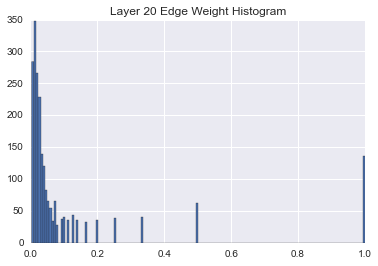

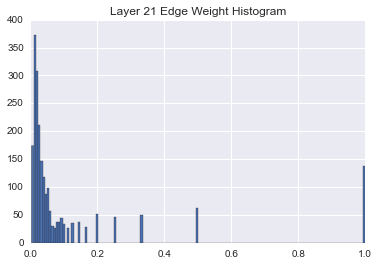

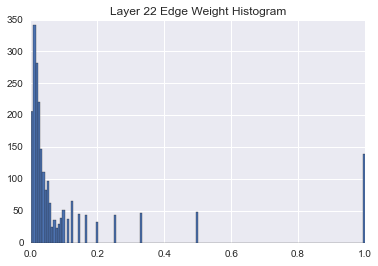

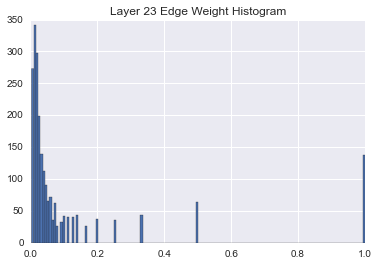

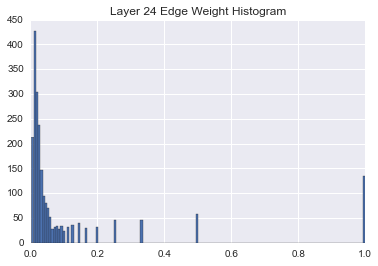

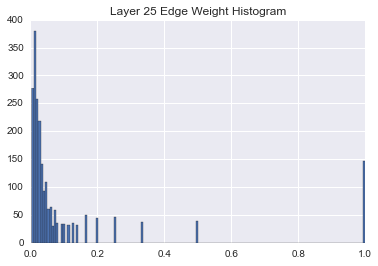

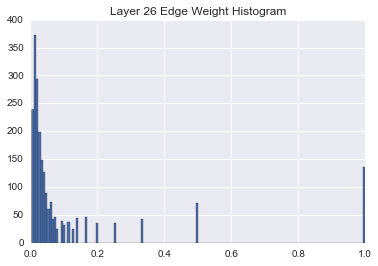

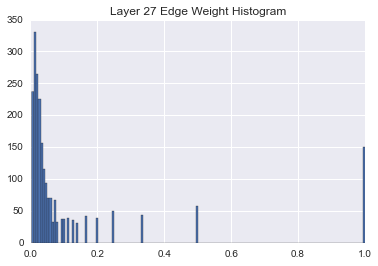

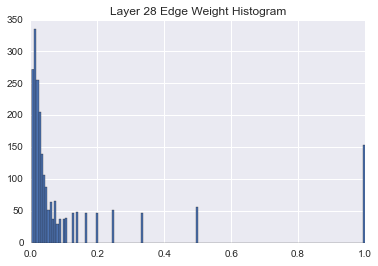

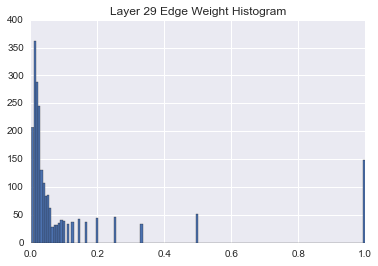

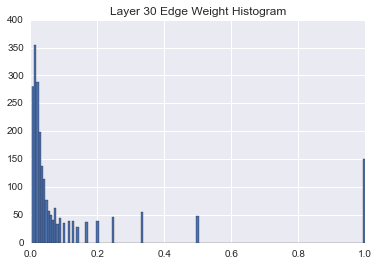

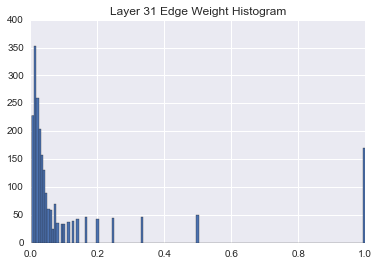

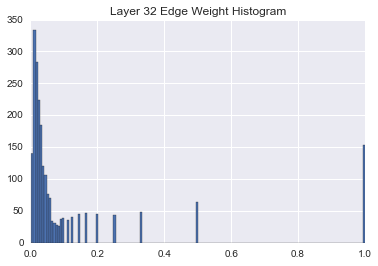

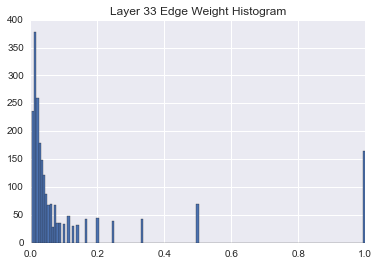

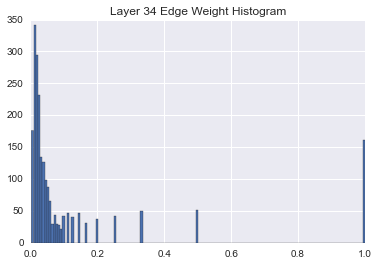

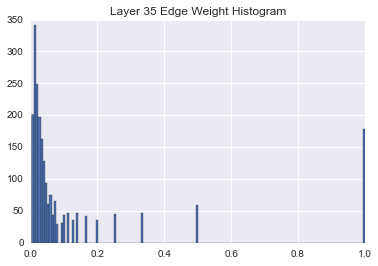

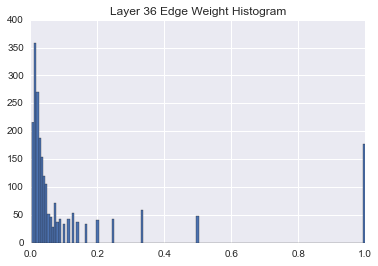

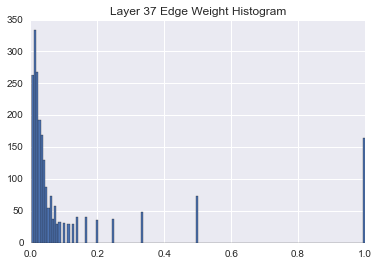

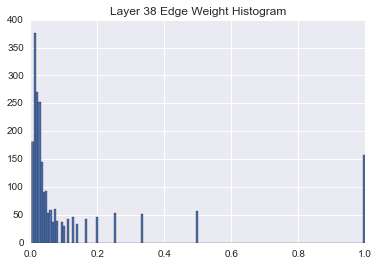

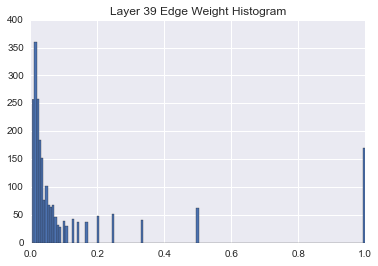

In [55]:
count = 0
for distr in distributions:
    plt.hist(distr, bins=150)
    plt.title("Layer " + str(count) + " Edge Weight Histogram")
    plt.show()
    count+=1

### Mean edge weights

In [56]:
y_edge_means = []
for distrib in distributions:
    y_edge_means.append(np.mean(distrib)) 

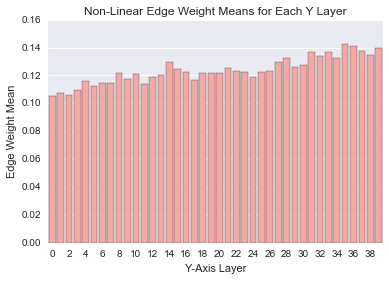

In [57]:
g = sns.barplot(x=range(len(y_edge_means)), y=y_edge_means, color='r')
g.set_xticks(g.get_xticks()[::2])
plt.xticks(g.get_xticks(), g.get_xticks())
plt.title("Non-Linear Edge Weight Means for Each Y Layer")
plt.xlabel("Y-Axis Layer")
plt.ylabel("Edge Weight Mean")
sns.plt.show()

### Edge Weight Variances

In [58]:
y_edge_vars = []
for distrib in distributions:
    y_edge_vars.append(np.var(distrib)) 

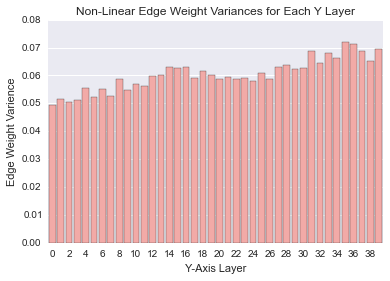

In [59]:
g = sns.barplot(x=range(len(y_edge_vars)), y=y_edge_vars, color='r')
g.set_xticks(g.get_xticks()[::2])
plt.xticks(g.get_xticks(), g.get_xticks())
plt.title("Non-Linear Edge Weight Variances for Each Y Layer")
plt.xlabel("Y-Axis Layer")
plt.ylabel("Edge Weight Varience")
sns.plt.show()

### Edge Weight Third Moments (Skewness)

In [60]:
y_edge_skews = []
for distrib in distributions:
    y_edge_skews.append(skew(distrib)) 

print y_edge_skews

[3.3308038971419425, 3.2524281591575845, 3.32830334059894, 3.2128313176188725, 3.0478811899700844, 3.149090398986711, 3.0713133153270156, 3.102355770738129, 2.941980285683584, 3.063534752004174, 2.9971373145129845, 3.1200643796153464, 3.0008752768927014, 2.942164671757787, 2.832314775071091, 2.8755603784435966, 2.9207421173840777, 3.0320129786446635, 2.9122676682773156, 2.9578585225971015, 2.951439188820325, 2.892376318454933, 2.9701471232252303, 2.9357901191206226, 2.9768764436668245, 2.956021158878956, 2.9128607153108566, 2.8244094443122334, 2.783983632674394, 2.882473287018431, 2.850764625116099, 2.693201033027961, 2.749259531472449, 2.6694316982251918, 2.756987960357808, 2.5901556902424794, 2.619434151718895, 2.640174014831771, 2.7396971933077565, 2.6337896071579396]


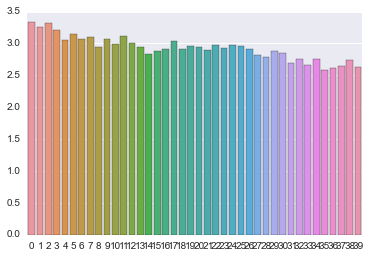

In [61]:
sns.barplot(x=range(len(y_edge_skews)), y=y_edge_skews)
sns.plt.show()

### Edge Weight Fourth Moments (Kurtosis)

In [65]:
y_edge_kurts = []
for distrib in distributions:
    y_edge_kurts.append(kurtosis(distrib)) 

print y_edge_kurts

[10.23804038626901, 9.659871939560425, 10.126489421844912, 9.487842928130155, 8.340949835038519, 9.079843616654733, 8.4577457245625, 8.796762945659259, 7.612789434857364, 8.450711707218769, 7.983654339058523, 8.617154019363616, 7.8199708817582145, 7.488860404537743, 6.836466100862996, 7.061271285090223, 7.228189540329977, 7.9896995574107095, 7.2965224485370275, 7.579757603659418, 7.6402543849600875, 7.329127582707219, 7.73957764837176, 7.541436736475237, 7.811626007448753, 7.5318810342862434, 7.445028685529282, 6.8050071473964575, 6.590949948186164, 7.108153535380023, 6.952258902862194, 5.938001000171235, 6.387577398849082, 5.859616601257473, 6.332259008643769, 5.356473182606829, 5.514073928343686, 5.703841872292106, 6.318236047886609, 5.642698148627998]


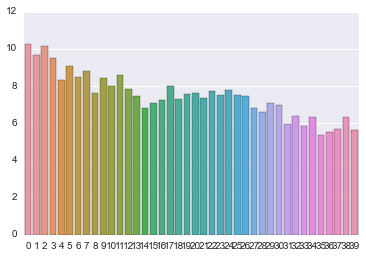

In [66]:
sns.barplot(x=range(len(y_edge_kurts)), y=y_edge_kurts)
sns.plt.show()

Hmmm...very interesting

## Linear graph weights
We're now going to change our weighting function to be linear and scaled by the max and min difference in each layer. This might help eliminates some of the edge effect behavior I suspect is causing that rapid change in statistics in deeper y-layers.

In [34]:
y_rags_linear_weight = []
for layer in real_volume:
    y_rags_linear_weight.append(generate_rag(layer, True))

In [35]:
test_rag = generate_rag(real_volume[4], True)
itty = test_rag.edges_iter()
weight_list = []
for index in range(test_rag.number_of_edges()):
    eddy = itty.next()
    weight_list.append(test_rag.get_edge_data(eddy[0], eddy[1])['weight'])

In [68]:
distributions_lin = get_edge_weight_distributions(y_rags_linear_weight)

# ignore edges
distributions_lin = distributions_lin[:40]

### Full edge weight histograms down y-axis

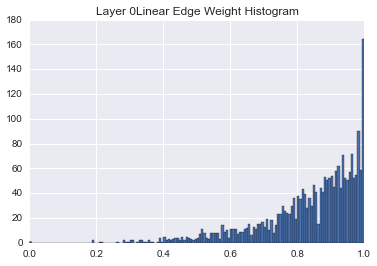

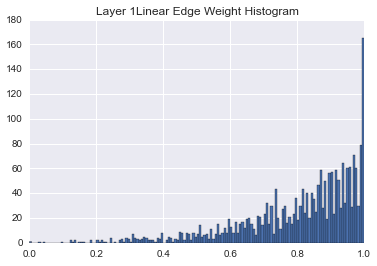

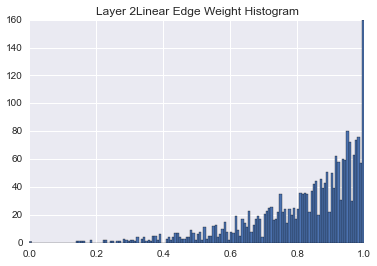

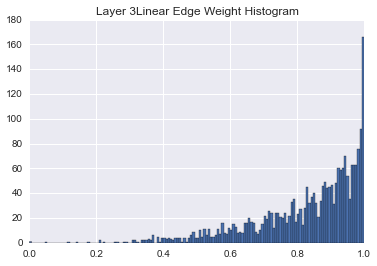

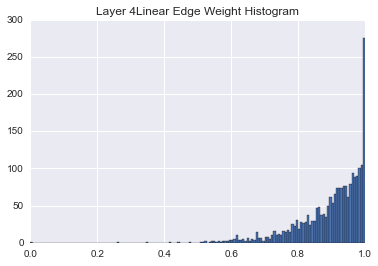

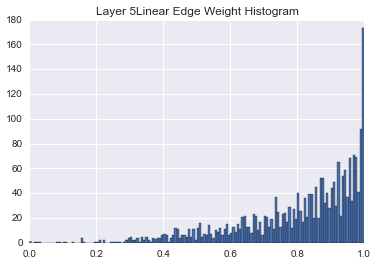

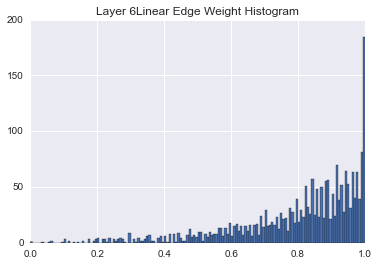

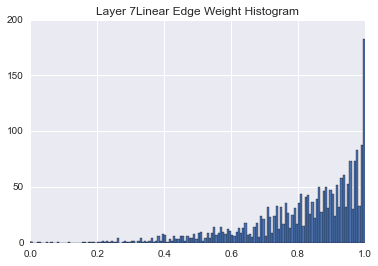

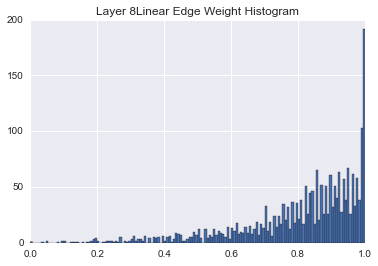

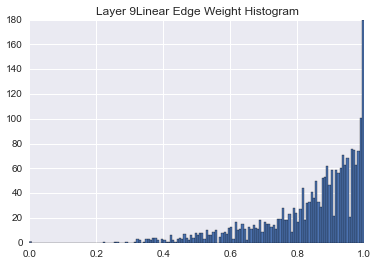

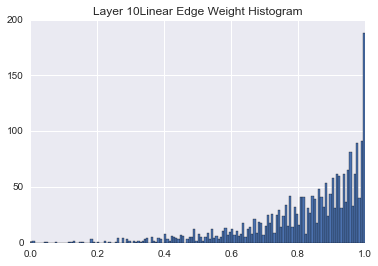

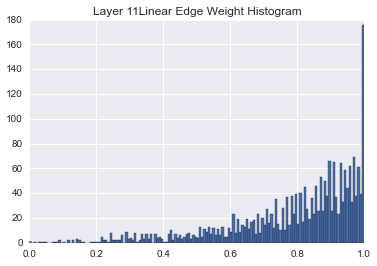

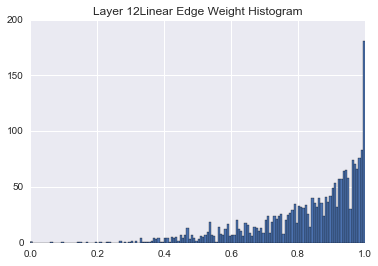

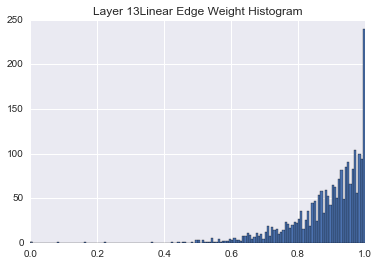

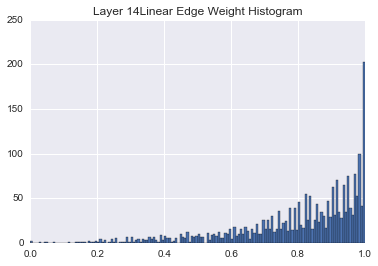

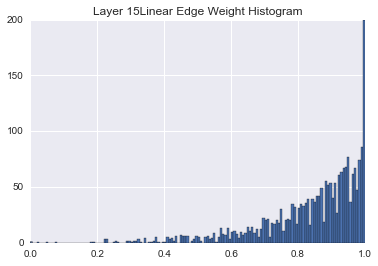

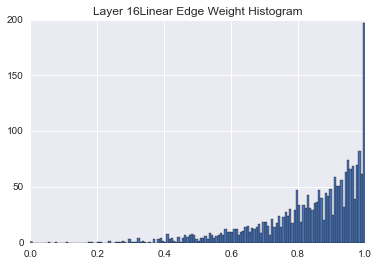

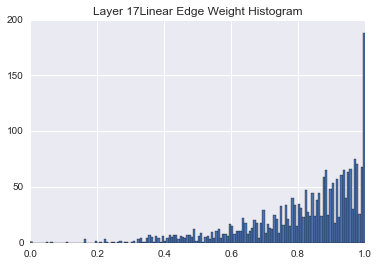

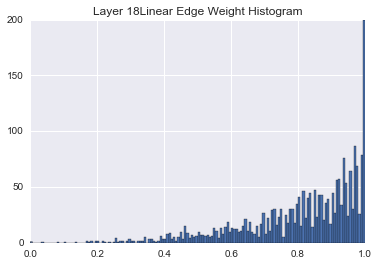

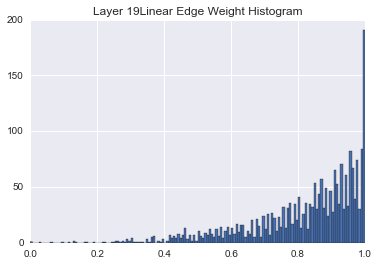

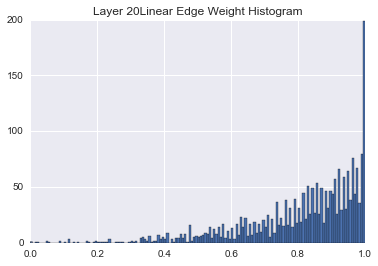

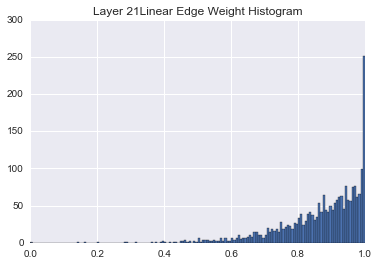

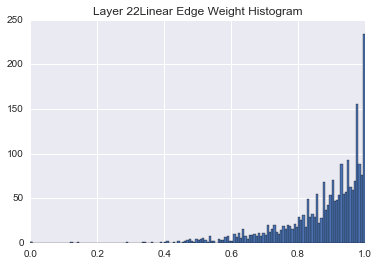

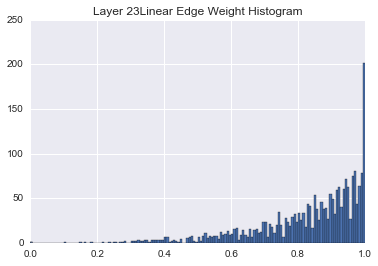

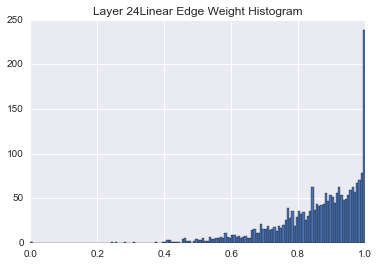

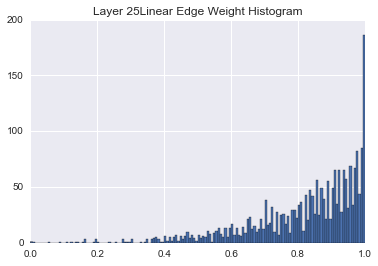

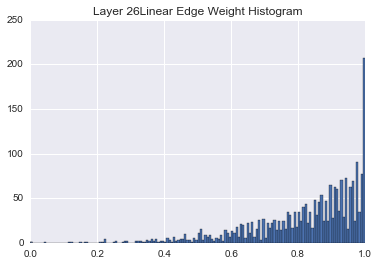

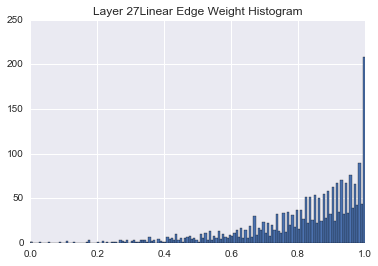

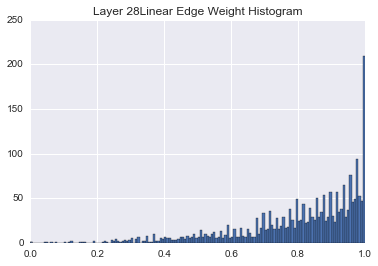

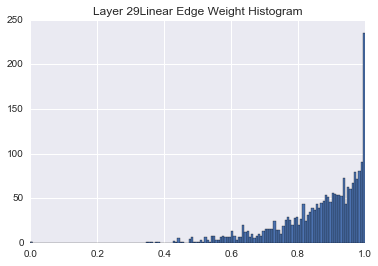

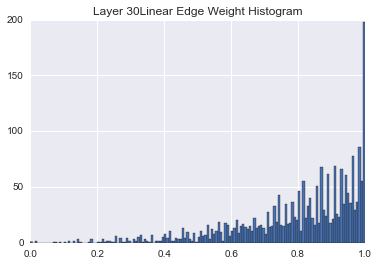

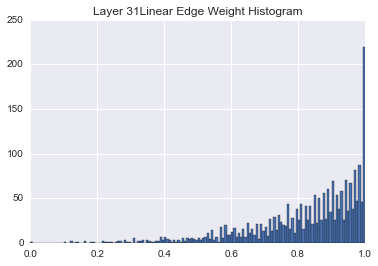

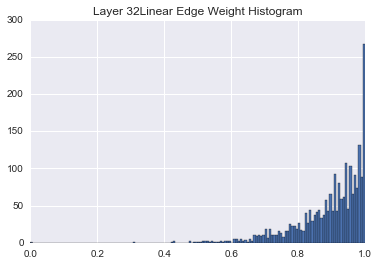

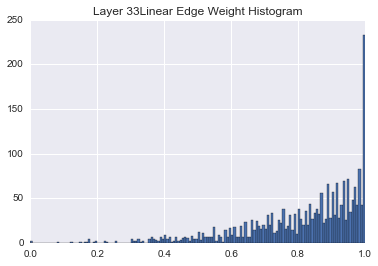

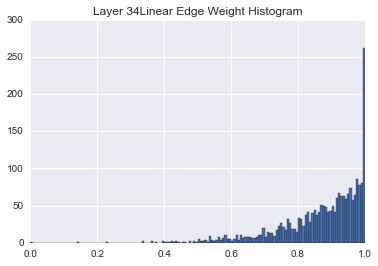

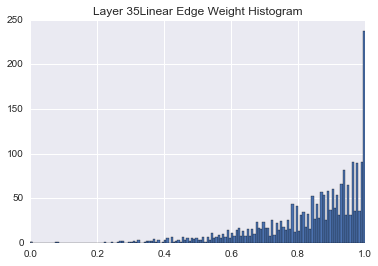

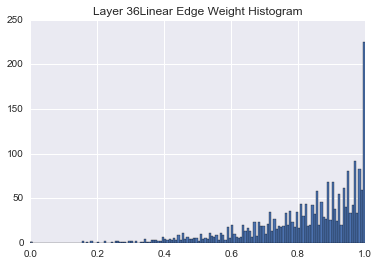

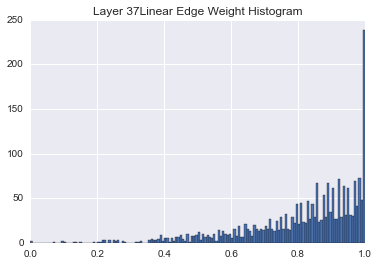

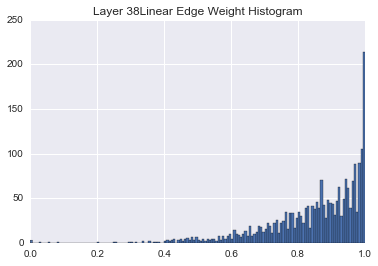

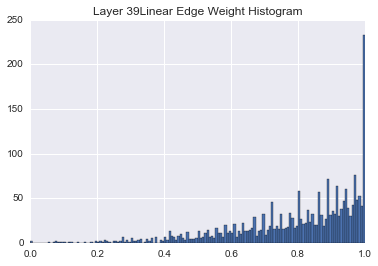

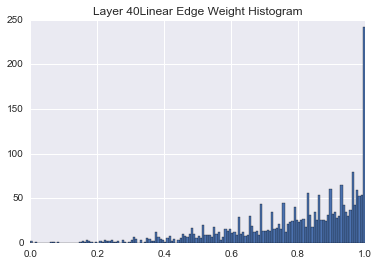

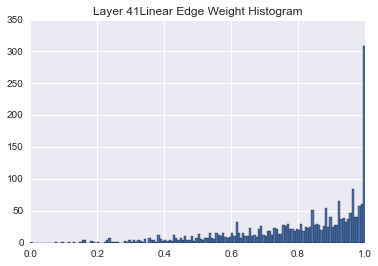

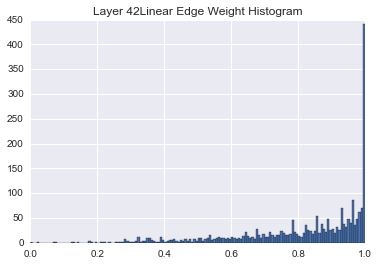

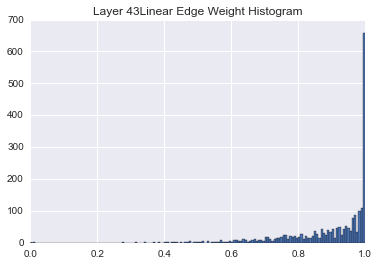

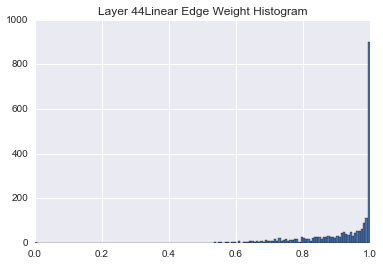

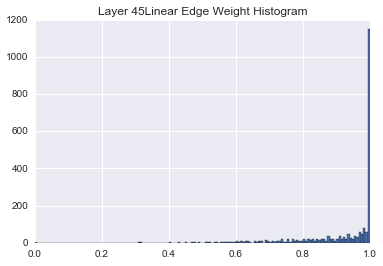

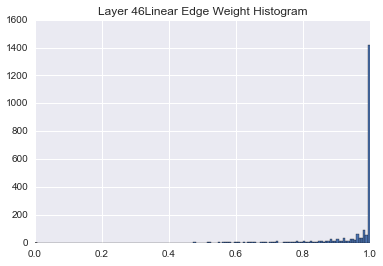

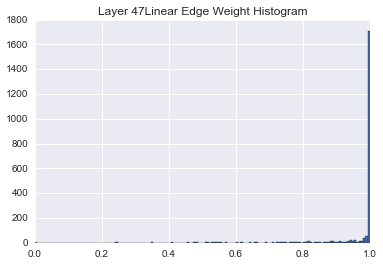

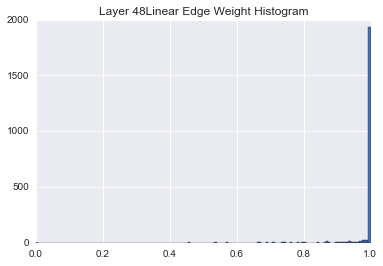

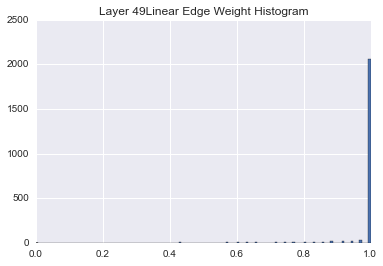

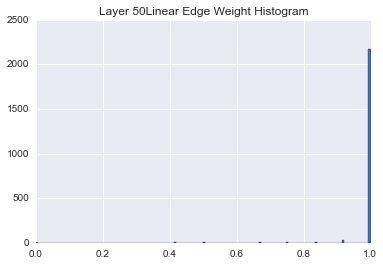

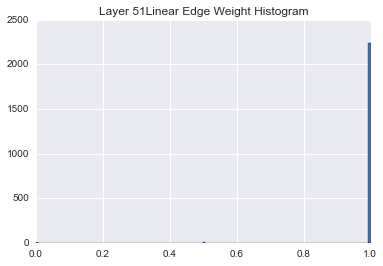

In [29]:
count = 0
for distr in distributions_lin:
    plt.hist(distr, bins=150)
    plt.title("Layer " + str(count) + "Linear Edge Weight Histogram")
    plt.show()
    count+=1

Note the very different shape of distributions. It might be interesting to see what the total edge weight distribution looks like for the full volume (all layers as one). Then we could compare the distributions generated by the two weighting functions.

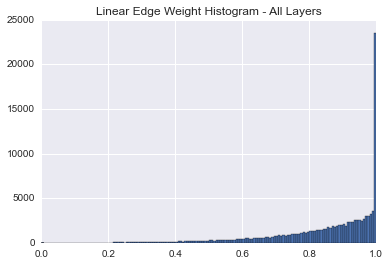

In [30]:
concat_distr = []
for distr in distributions_lin:
    concat_distr = concat_distr + distr

plt.hist(concat_distr, bins=150)
plt.title("Linear Edge Weight Histogram - All Layers")
plt.show()

Intersting. Now let's go back and compare that to the non-linear, unscaled weighting.

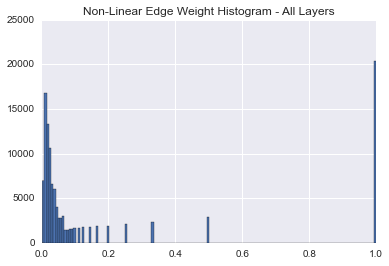

In [31]:
concat_distr2 = []
for distr in distributions:
    concat_distr2 = concat_distr2 + distr

plt.hist(concat_distr2, bins=150)
plt.title("Non-Linear Edge Weight Histogram - All Layers")
plt.show()

Very interesting. Why would that behavior arise from a non-linear function? Is this a property of the data or just the math? Either way, let's continue on with other statistic through the layers generated by the the linearly weighted RAG.

### Linear Edge Weight Means

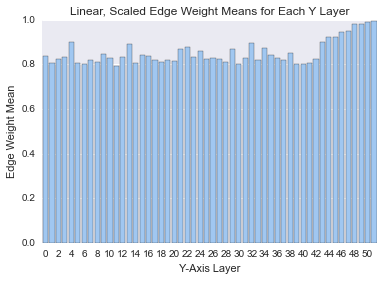

In [67]:
y_edge_linear_means = []
for distrib in distributions_lin:
    y_edge_linear_means.append(np.mean(distrib)) 

g = sns.barplot(x=range(len(y_edge_linear_means)), y=y_edge_linear_means, color='b')
g.set_xticks(g.get_xticks()[::2])
plt.xticks(g.get_xticks(), g.get_xticks())
plt.title("Linear, Scaled Edge Weight Means for Each Y Layer")
plt.xlabel("Y-Axis Layer")
plt.ylabel("Edge Weight Mean")
sns.plt.show()

Visually, we can see significant peaks at layers 4, 9, 13, 22, and 32. Let's compare that to the density sum plot. Perhaps that corroborates the evidence we saw earlier from the layer-by-layer density sums.

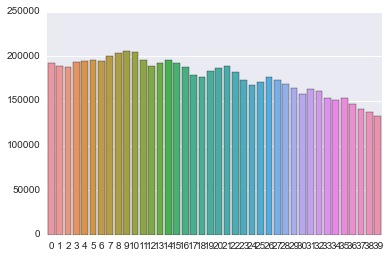

In [35]:
y_sum = [0] * len(vol[0,:,0])
for i in range(len(vol[0,:,0])):
    y_sum[i] = sum(sum(vol[:,i,:]))
sns.barplot(x=range(len(y_sum[:40])), y=y_sum[:40])

We see peaks at layers 9, 14, 21, 26, 31, and possibly 35. While the patterns in the edge weight means are not as consistent or noticable, the peaks are fairly close, especially in the first peaks. We could test this by looking at local minima and maxima analytically.

### Linear Edge Weight Variance

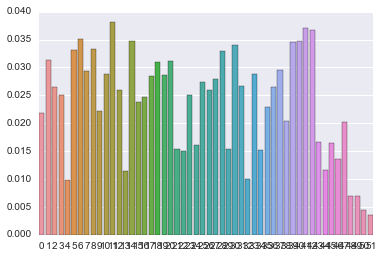

In [30]:
y_edge_linear_vars = []
for distrib in distributions_lin:
    y_edge_linear_vars.append(np.var(distrib)) 

sns.barplot(x=range(len(y_edge_linear_vars)), y=y_edge_linear_vars)
sns.plt.show()

### Linear Edge Weight Skewness

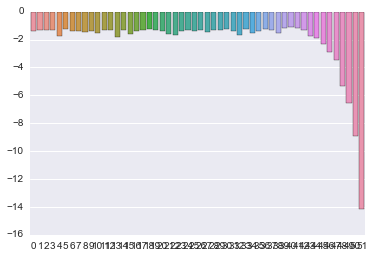

In [31]:
y_edge_linear_skews = []
for distrib in distributions_lin:
    y_edge_linear_skews.append(skew(distrib)) 

sns.barplot(x=range(len(y_edge_linear_skews)), y=y_edge_linear_skews)
sns.plt.show()

### Linear Edge Weight Kurtosis

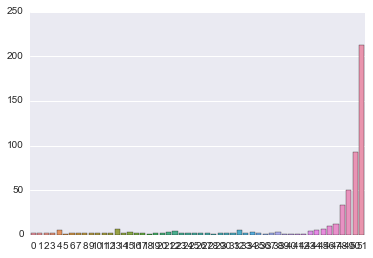

In [32]:
y_edge_linear_kurts = []
for distrib in distributions_lin:
    y_edge_linear_kurts.append(kurtosis(distrib)) 

sns.barplot(x=range(len(y_edge_linear_kurts)), y=y_edge_linear_kurts)
sns.plt.show()

### Number of Self Loops

In [ ]:
num_self_loops = []
for rag in y_rags:
    num_self_loops.append(rag.number_of_selfloops())

In [ ]:
num_self_loops

Interesting. There are no self loops. Why would this be? Let's come back to this. In the meantime, I want to give some though to what it means to have a self loop, whether it should be theoretically possible given our data, and whether our graphs are formed properly.

The answer to this question is very simple. In a RAG, there are no self-loops by definition. Self loops are edges that form a connection between a node and itself.

<img src="../../docs/figures/selfloop.png" width="100">

To see whether the graphs are formed properly, let's look at an adjacency lists:

In [ ]:
# y_rags[0].adjacency_list()

Compare that to the test data:

In [ ]:
# Test Data
test = np.array([[1,2],[3,4]])
test_rag = skimage.future.graph.RAG(test)
test_rag.adjacency_list()

### X-Layers

In [ ]:
real_volume_x = np.zeros((len(sorted_x), len(sorted_y), len(sorted_z)))
for r in rows:
    real_volume_x[ sorted_x.index(r[0]), sorted_y.index(r[1]), sorted_z.index(r[2])] = r[-1]

In [ ]:
x_rags = []
count = 0;
for layer in real_volume_x:
    count = count + 1
    x_rags.append(skimage.future.graph.RAG(layer))

In [ ]:
num_edges_x = []
for rag in x_rags:
    num_edges_x.append(rag.number_of_edges())

In [ ]:
sns.barplot(x=range(len(num_edges_x)), y=num_edges_x)
sns.plt.show()

We can see here the number of edges is low in that area that does not have many synapses. It, as expected, mirrors the distribution of synapses. It appears to be approximately uniform at the top, with buffers of very few synapses on the sides. Remember from here:

In [ ]:
plt.imshow(np.amax(real_volume, axis=2), interpolation='nearest')
plt.show()

In [ ]:
# edge_length_list[3]
# tri_area_list[3]
# triangles

In [ ]:
# Note for future
# del_features['d_edge_length_mean'] = np.mean(edge_lengths)
# del_features['d_edge_length_std'] = np.std(edge_lengths)
# del_features['d_edge_length_skew'] = scipy.stats.skew(edge_lengths)
# del_features['d_edge_length_kurtosis'] = scipy.stats.kurtosis(edge_lengths)